## Creation of virtual sources

Dans ce projet, on cherche à simuler le comportement d'une surface tactile. Pour ce faire, on commence par choisir un point d'impact, à partir duquel une onde (sinusoïde modulée par une gaussienne) sera émise. 

Dans un premier temps, on a calculé les positions des fontaines virtuelles à partir de la réflexion du point source sur les quatre côtés de la surface. Les sources virtuelles d'ordre 1 résultent d'une seule réflexion, l'ordre 2 implique 2 réflexions, et ainsi de suite. Toutefois, cette méthode prend beaucoup de temps, car il répète plusieurs positions de sources virtuelles lorsque l'ordre augmente. Par conséquent, une fois qu’on a connu le résultat qu'on devait obtenir, on a déduit le motif formé par ces sources et écrit le code qui calculerait leurs positions de cette manière. Cela permet un gain important du temps de calcul.

Le code utilisé et son résultat (pour l’ordre 30) sont présentés ci-dessous :


In [546]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import time


In [547]:

def reflect_mur(a,b, x0, y0, mur):
    sol = 0
    if mur == 1 :
        sol = [x0 - (2*x0), y0]
    elif mur == 2 :
        sol = [x0 + 2*(a-x0), y0]
    elif mur == 3 :
        sol = [x0, y0 - (2*y0)]
    elif mur == 4 :
        sol = [x0, y0 + 2*(b-y0)]
    return sol

def virtual_sources(a,b,x0,y0,order):
    
    already = [[x0,y0]]
    point1 = 0 
    point2 = len(already)
    virtual_source = {}
    
    if order > 0:
        for i in range(int(order)) :
            new = []
            for j in range(point1,point2) :
                for k in range(4) :
                    new_cord = reflect_mur(a,b,already[j][0],already[j][1],k+1)
                    if new_cord not in already :
                        new.append(new_cord)
                        already.append(new_cord)
            point1 = point2
            point2 = len(already)
            virtual_source[i+1] = new
        
    return virtual_source




Avec le code suivant, les sources virtuelles sont tracées en fonction de leur ordre.


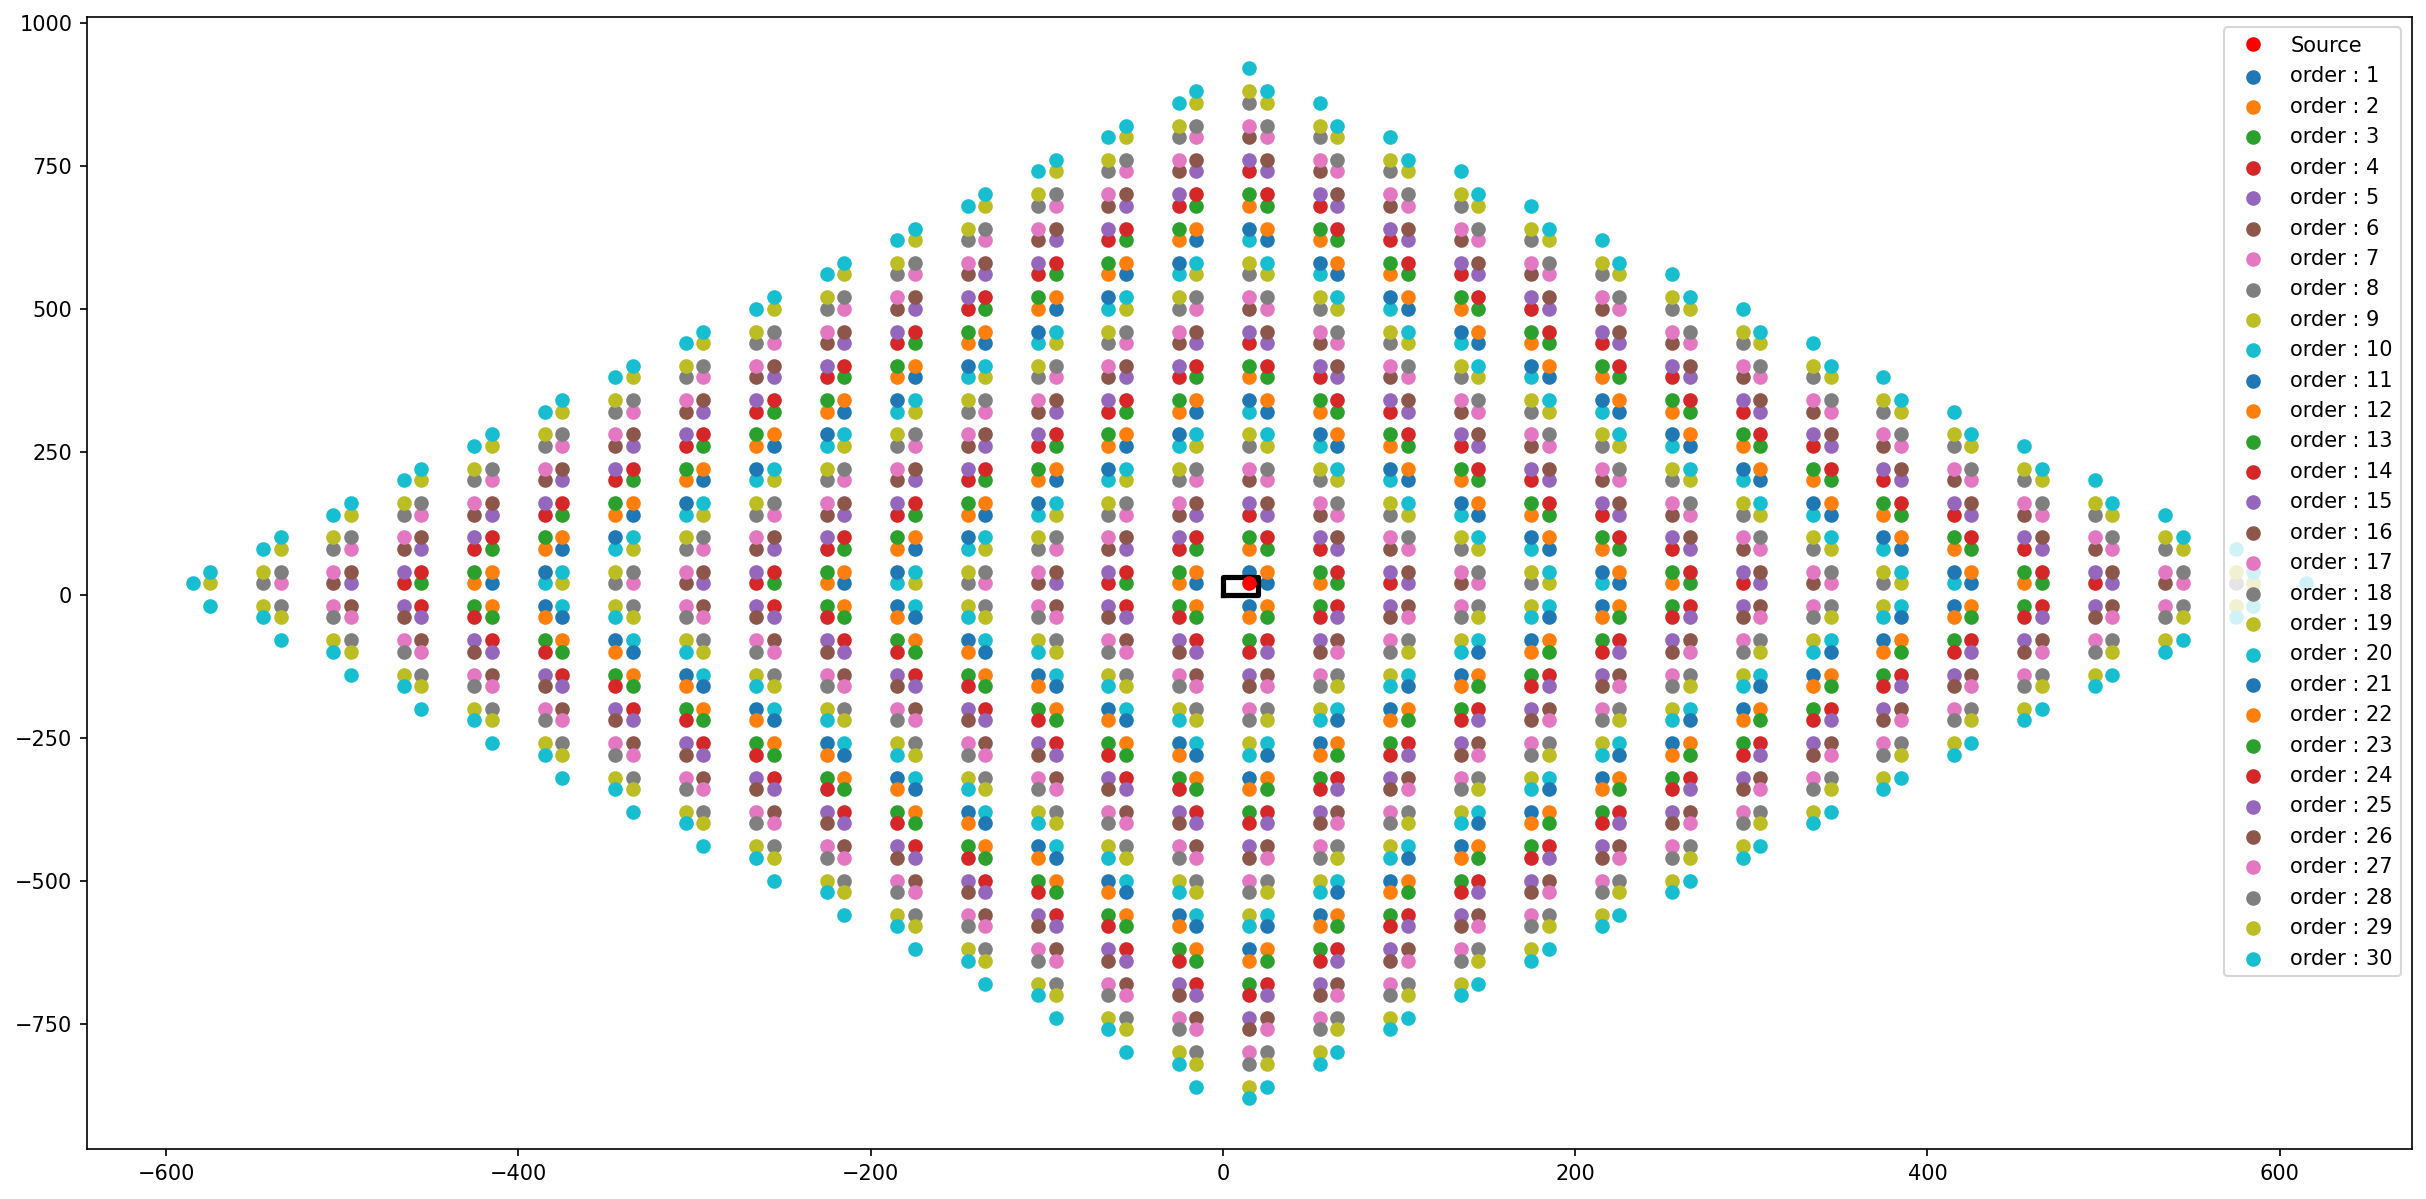

In [548]:
a = 20
b = 30
x0 = 15
y0 = 20
order = 30

results = virtual_sources(a,b,x0,y0,order)
total = np.array([[0,0]])

plt.figure(figsize=(20, 10), dpi=150)
plt.plot([0, a, a, 0, 0], [0, 0, b, b, 0], c = 'k', linewidth=2.5)

for i in range(order) :
    aux = np.array(results[i+1])
    total = np.concatenate((total,aux),axis = 0)
    plt.scatter(aux[:,0],aux[:,1], label =  "order : {}".format(i+1))

plt.plot(x0,y0,'ro', label = 'Source')
plt.legend()
plt.show()
total = np.delete(total,0,0)


Pour cela, on utilise la fonction "reflect_mur", avec laquelle sont calculées les translations des sources virtuelles, correspondant à une réflexion sur chacun des murs. Ensuite, dans la fonction "virtual_sources", dans la liste "already", la position du premier point (la source) est stockée. Ensuite, selon l'ordre, les sources virtuelles sont générées dans la première boucle. Dans la deuxième boucle, les positions qui ont été créées dans l'ordre correspondant sont "traversées" ; par exemple, pour l'ordre 1, 4 sources virtuelles sont générées, puis, pour générer les sources de l'ordre 2, il est traversé de la position 1 à 4. Par conséquent, dans chaque boucle, la valeur de "point1" et "point2" change. 

On crée dans la variable "newcord" la coordonnée de chaque source virtuelle et on la stocke dans "already", en vérifiant d'abord qu'elle ne figure pas déjà dans cette liste, afin de ne pas répéter des points. Dans la liste "new", seuls les résultats de chaque commande sont stockés; dans "already", toutes les coordonnées calculées pour toutes les commandes sont stockées.


# Creation of impulse signal and receptors

Pour générer l'onde initiale, on a utilisé ce qu'on a appris précédemment en classe pour générer une onde sinusoïdale modulée par une gaussienne; "t" correspond à la durée du signal et "tm" au temps auquel il est centré. 

In [549]:
def impulse(t,tm) :
    fc = 1.5 #MHz
    BP = 1 #100%
    
    alpha = (np.pi*(BP*fc/2)**2)/np.log(2)
    s1 = np.exp(-alpha*(t-tm)**2)
    s2 = np.sin(2*np.pi*fc*(t-tm))
    s = 10*s1*s2
    
    return s


La fonction "signal_pattern" calcule la distance entre la source originale et chacune des sources virtuelles; en divisant par la vitesse de propagation de la vibration (24000 m/s), son temps de propagation vers chaque source virtuelle est calculé et l'impulsion est centrée à ces temps, afin d'être caractéristique pour chaque distance.

Dans les vecteurs "Temp1" et "Temp2" sont stockés les temps qui ont été utilisés pour centrer les impulsions sur les sources virtuelles. Dans les vecteurs "Amp1" et "Amp2" l'amplitude résultante du signal est stockée après avoir été multipliée par un coefficient de réflexion (on a considéré 0.8) et divisée par la racine carrée de la distance. Il faut considérer que, si une onde subit 2 réflexions, elle subit une atténuation dans chacune d'elles ; donc, on multiplie en fait par 0,8^ordre. A partir de ces valeurs d'amplitude et de temps, on calcule le signal mesuré à chaque récepteur (superposition des signaux individuels des sources virtuelles).



In [550]:
def signal_pattern(X0,X1,X2,C,tf,N,order) :
    
    #INFORMATION FOR THE WAVE
    
    c = 2400*100*10e-6 # 2400m/s - > cm/micro s
    dt = tf/(N-1)
    fe = 1/dt #MHz
    t = np.linspace(0, dt*(N-1), N) # micro s
    df = 1/(N*dt) #MHz
    f = np.linspace(0, df*(N-1), N) #MHz

    D1 = np.linalg.norm(X0 - X1) #cm
    D2 = np.linalg.norm(X0 - X2) #cm
    t1 = D1/c #micro s
    t2 = D2/c #micro s
    
    Amp1 = [1/D1]
    Amp2 = [1/D2]
    Temp1 = [t1]
    Temp2 = [t2]

    S1_virtual = Amp1*impulse(t,t1)
    S2_virtual = Amp2*impulse(t,t2)
    virtualsource = virtual_sources(a,b,X0[0,0],X0[0,1],order)
    
    if order > 0 :
        for i in range(order): 
            aux = np.array(virtualsource[i+1]) #Results each order
            D1 = np.linalg.norm(aux - X1, axis = 1)
            D2 = np.linalg.norm(aux - X2, axis = 1)
            t1 = D1/c
            t2 = D2/c 

            for j in range(len(t1)) :
                A1 = C**(i+1)/np.sqrt(D1[j])
                A2 = C**(i+1)/np.sqrt(D1[j])
                S1_virtual += A1*impulse(t,t1[j])
                S2_virtual += A2*impulse(t,t2[j])
                Temp1.append(t1[j])
                Temp2.append(t2[j])
                Amp1.append(A1)
                Amp2.append(A2)
    
    t1 = np.array(Temp1)
    t2 = np.array(Temp2)
    A1 = np.array(Amp1)
    A2 = np.array(Amp2)
    
    return t, t1, t2, S1_virtual, S2_virtual, A1, A2

Le graphique suivant montre l'atténuation de l'amplitude des signaux en fonction du temps.


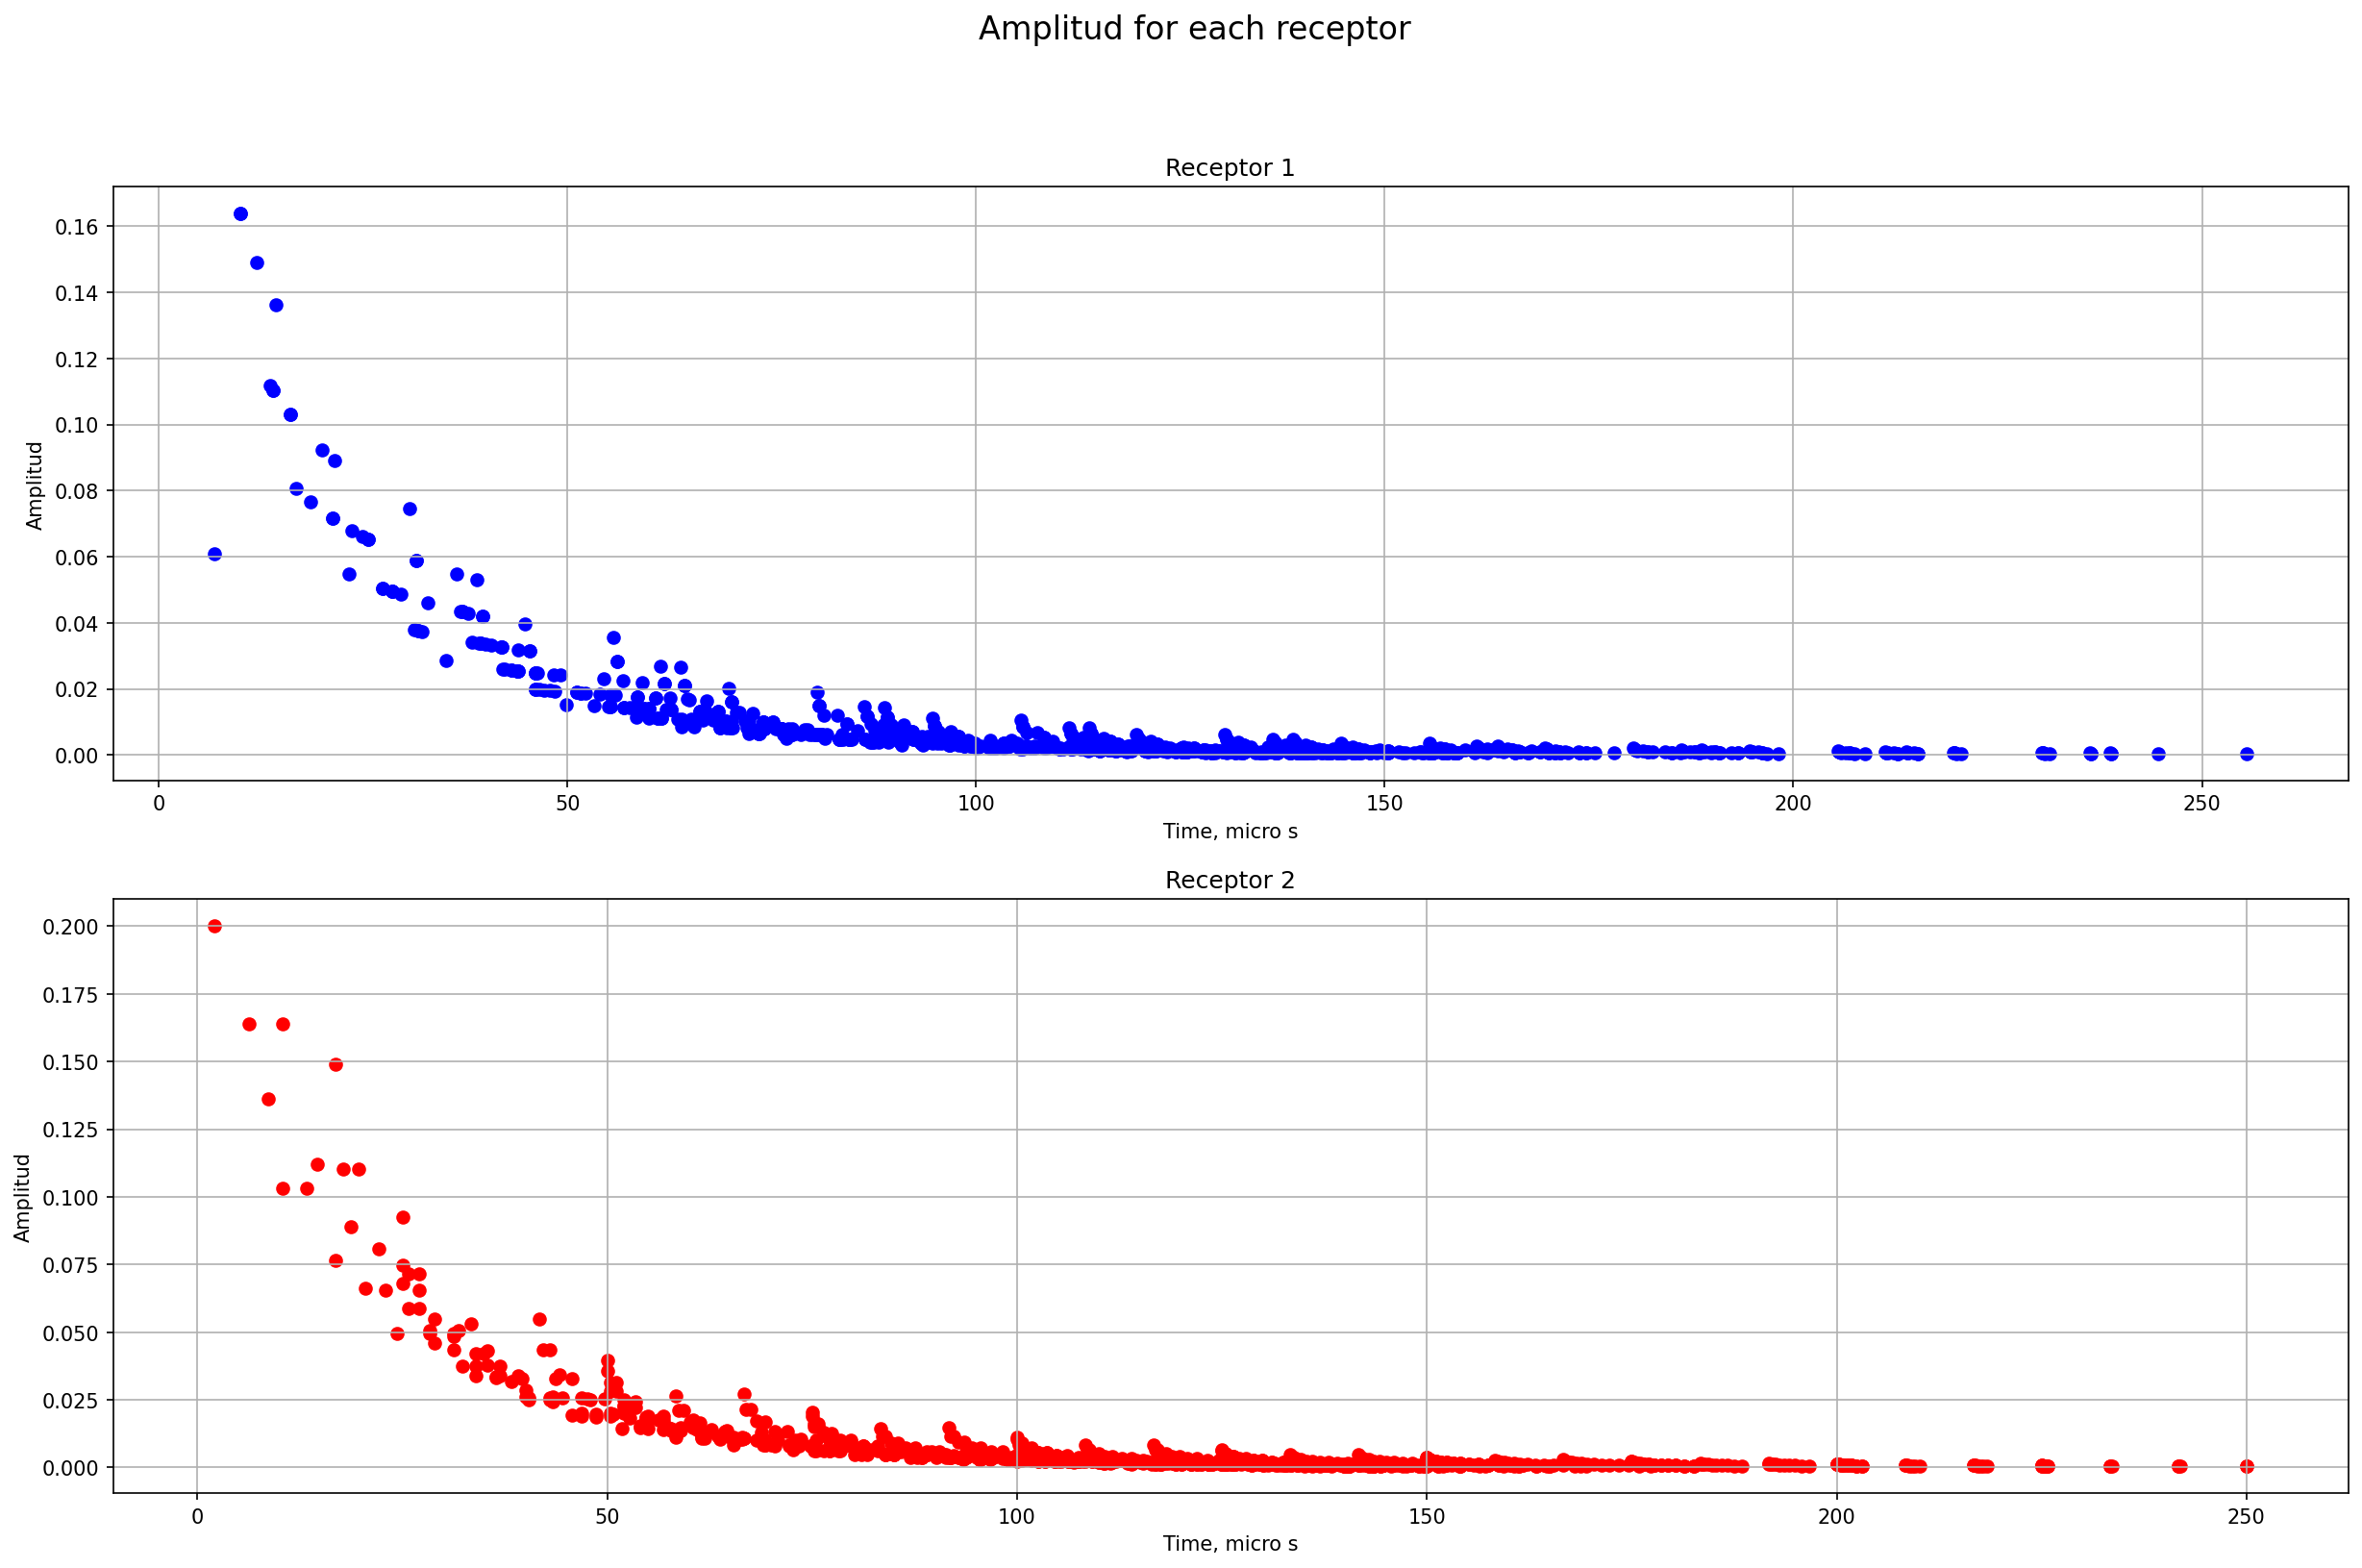

In [551]:

# Positions of the receptors

a = 20
b = 30

x0 = 15
y0 = 20
X0 = np.array([[x0,y0]])

x1 = 5
y1 = 7
X1 = np.array([[x1,y1]])

x2 = 10
y2 = 20
X2 = np.array([[x2,y2]])

# Information about the wave

N =  1024
C = 0.8
tf = 200
order = 20

t, t1, t2, S1_virtual, S2_virtual, A1, A2 = signal_pattern(X0,X1,X2,C,tf,N,order) 

fig = plt.figure(figsize=(20, 12), dpi=150)

fig.suptitle('Amplitud for each receptor', fontsize=16)

plt.subplot(2,1,1)
plt.scatter(t1,A1,c='b')
plt.title('Receptor 1')
plt.xlabel('Time, micro s')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,1,2)
plt.scatter(t2,A2,c='r')
plt.title('Receptor 2')
plt.xlabel('Time, micro s')
plt.ylabel('Amplitud')
plt.grid()

plt.show()


Ensuite, on désigne deux points de position aléatoire comme récepteurs du signal, sur lesquels on mesure la superposition de toutes les réflexions subies par l'onde initiale. 

Ce sont les signaux mesurés aux récepteurs.


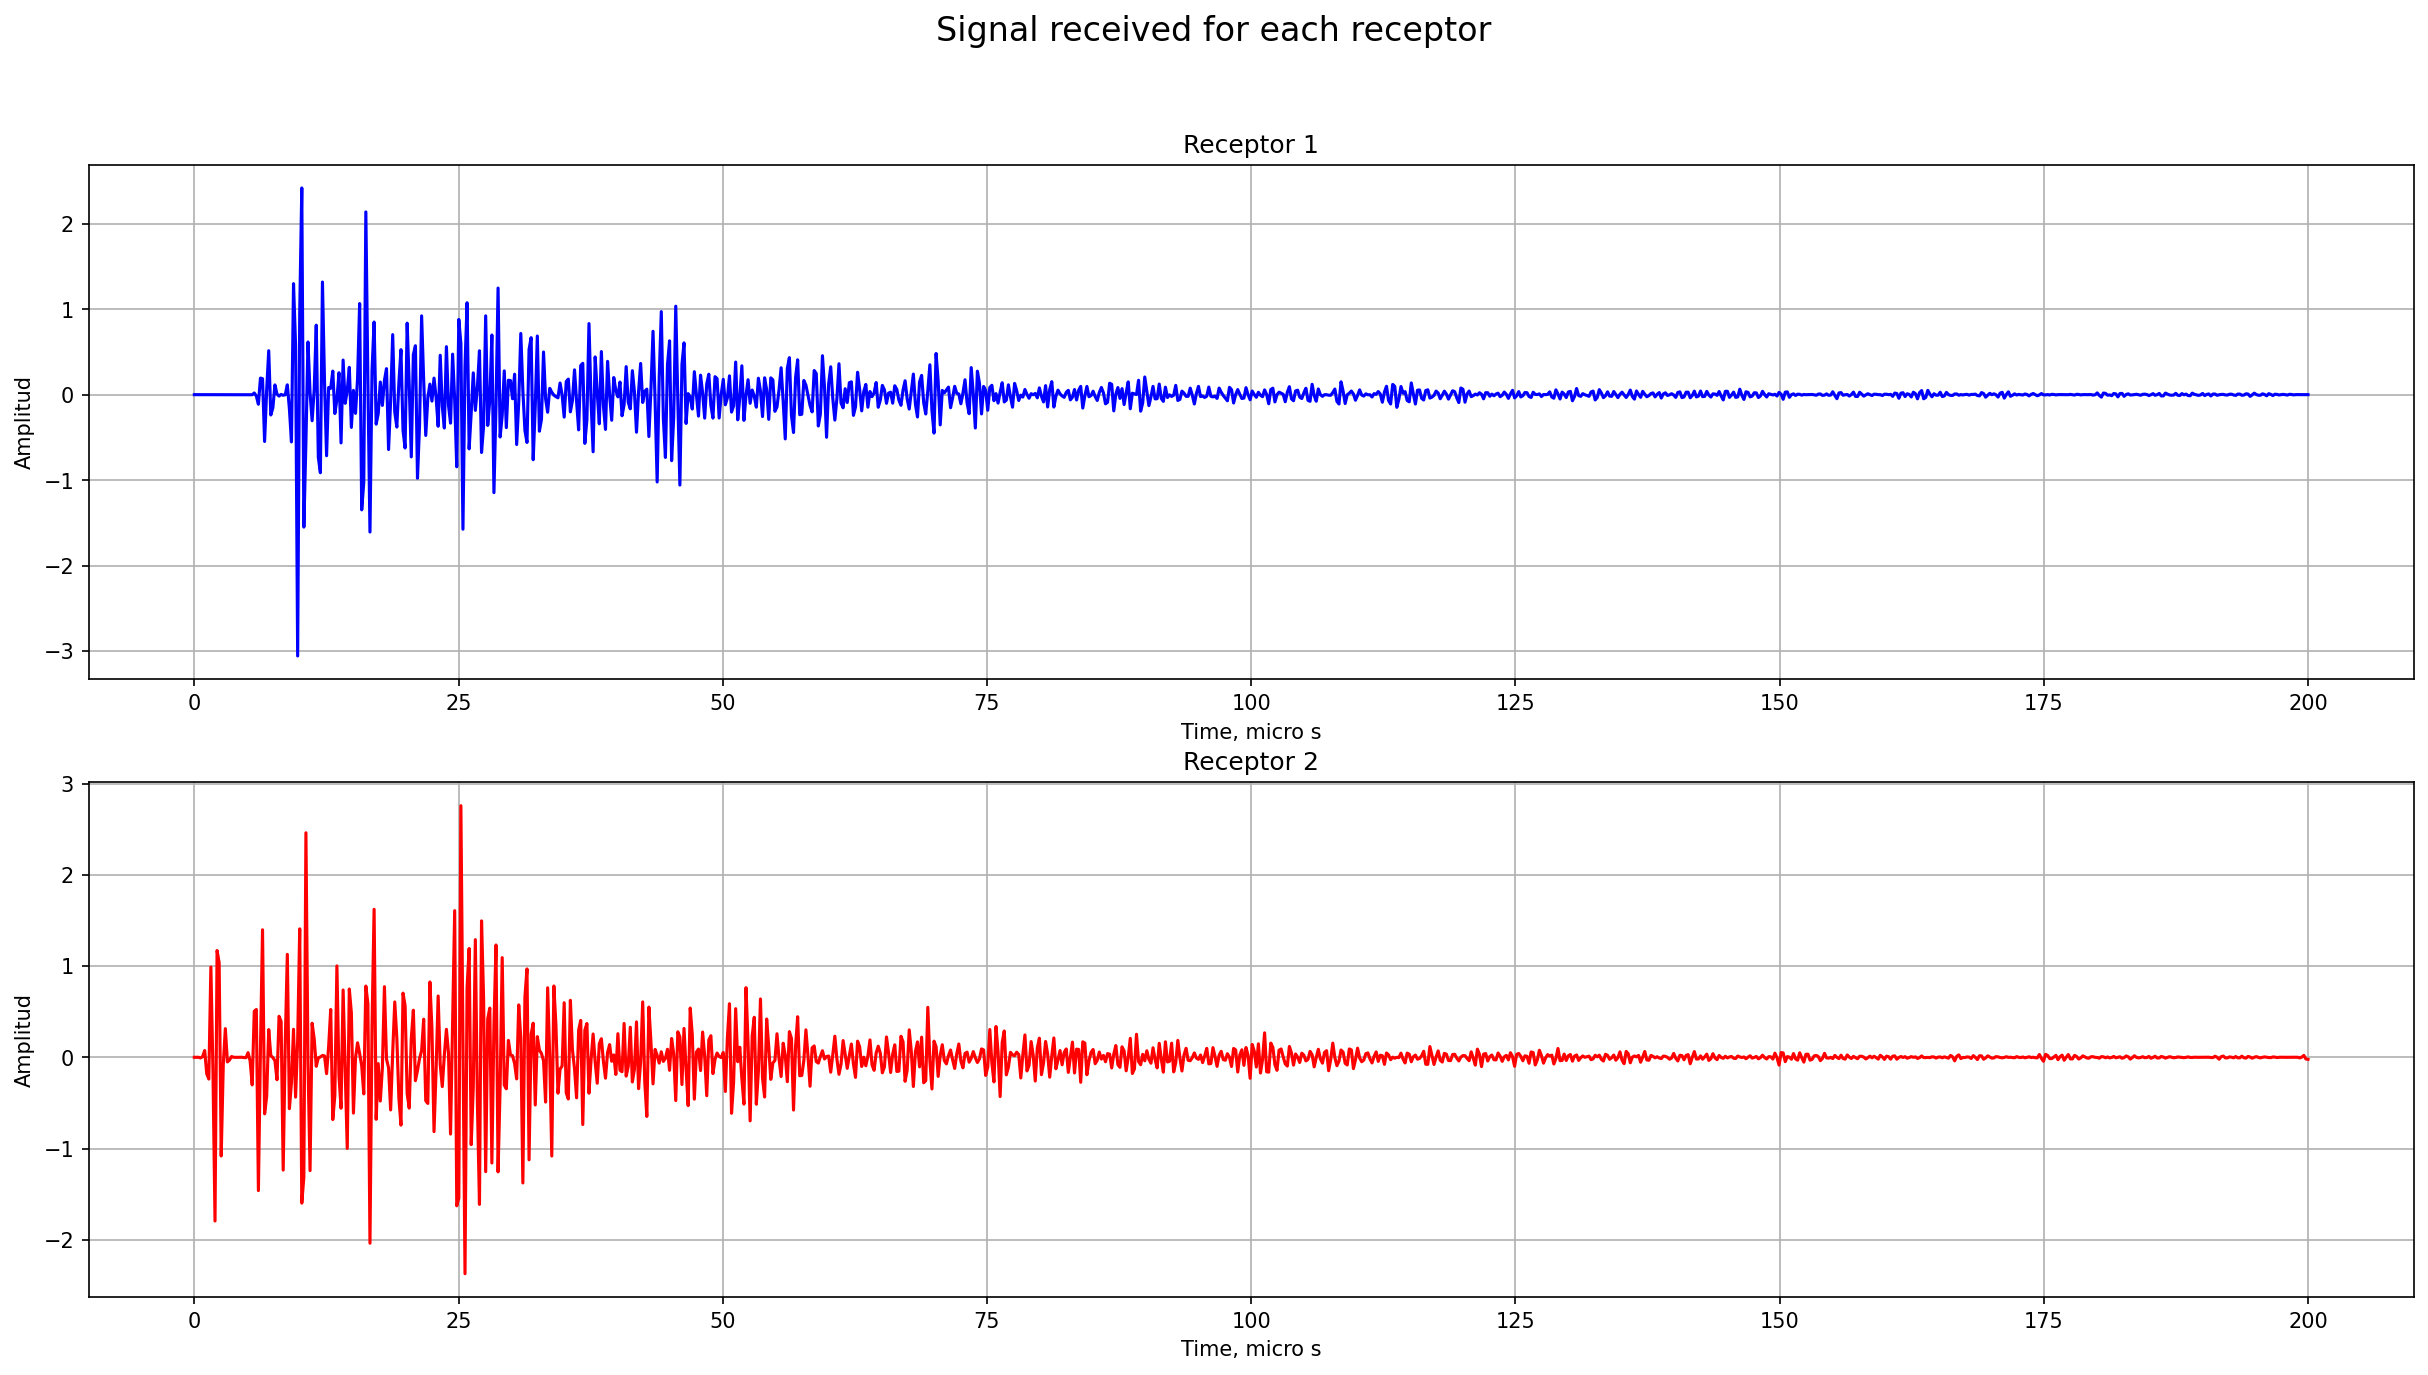

In [552]:
fig = plt.figure(figsize=(20, 10), dpi=150)

fig.suptitle('Signal received for each receptor', fontsize=16)

plt.subplot(2,1,1)
plt.plot(t,S1_virtual, 'b')
plt.title('Receptor 1')
plt.grid()
plt.xlabel('Time, micro s')
plt.ylabel('Amplitud')

plt.subplot(2,1,2)
plt.plot(t,S2_virtual,'r')
plt.title('Receptor 2')
plt.grid()
plt.xlabel('Time, micro s')
plt.ylabel('Amplitud')
plt.show()

# Correlation function

Le premier élément dont on a besoin est de pouvoir quantifier la ressemblance de deux signaux, qui peuvent être d’amplitudes différentes et éventuellement décalés en temps. On définit pour cela l’opération
de corrélation selon la formule suivante :

$C(s_1,s_2) = \frac{1}{\sqrt{e_1 e_2}} max| \int_{-\infty}^{\infty} s_1(\tau) s_2(\tau-t) d\tau|$

Où e1 et e2 sont les énergies totales des deux signaux s1(t) et s2(t). Ici, les énergies totales des deux signaux ont été calculées selon la formule suivante. 

$ e_i = \sum_{n=-\infty}^{\infty} s_i[n]^2$

Selon l'égalité de Schwartz, le coefficient de corrélation est compris entre 0 et 1. Ce qui signifie que pour deux signaux identiques ayant la même amplitude et la même différence de temps, la corrélation sera de 1. Plus la corrélation est proche de 1, plus les signaux sont similaires.

On peut noter que l’opération de corrélation a une forte ressemblance avec l'intégrale de convolution, présentée ci-dessous. 

$(f*g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t-\tau) d\tau$

Par conséquent, pour calculer la corrélation, on a suivi les étapes ci-dessous:

-Le signal S2 a été "inversé" dans le temps.

-La FFT de S1 et S2 a été calculée, puis on a multiplié ces résultats.

-La FFT inverse du signal obtenu a été calculée.


In [553]:
def correlation_all(S1_virtual,S2_virtual) :

    e1 = np.sum(S1_virtual**2)
    e2 = np.sum(np.flip(S2_virtual**2))
    S1_TF = np.fft.fft(S1_virtual)
    S2_TF = np.fft.fft(np.flip(S2_virtual))
    S12 = S1_TF*S2_TF

    s12 = np.fft.ifft(S12)
    C_factor = np.abs(s12)/np.sqrt(e1*e2)
    print(np.max(C_factor))
    
    return C_factor, S1_TF, S2_TF, S12

def correlation(S1_virtual,S2_virtual) :

    e1 = np.sum(S1_virtual**2)
    e2 = np.sum(np.flip(S2_virtual**2))
    S1_TF = np.fft.fft(S1_virtual)
    S2_TF = np.fft.fft(np.flip(S2_virtual))
    S12 = S1_TF*S2_TF

    s12 = np.fft.ifft(S12)
    C_factor = np.abs(s12)/np.sqrt(e1*e2)
    
    return np.max(C_factor)


Le graphique et la valeur obtenus pour la corrélation des deux signaux sont présentés ci-dessous.

0.25947640426284724


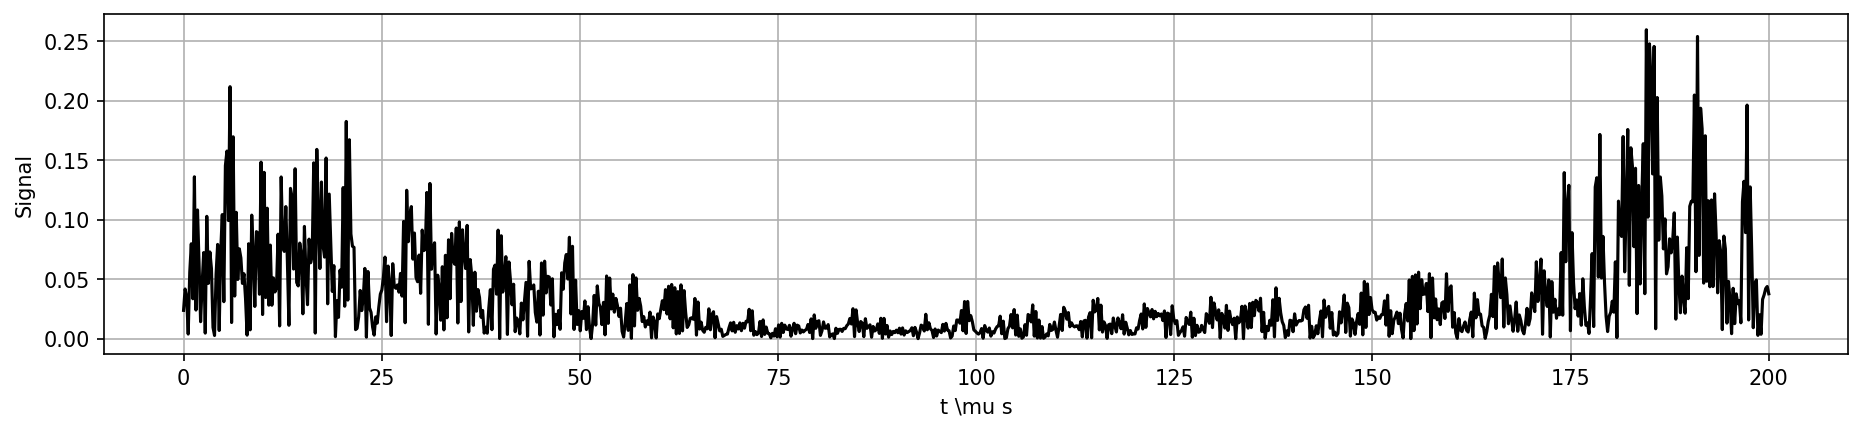

In [554]:
C_factor, S1_TF, S2_TF, S12 = correlation_all(S1_virtual,S2_virtual)

plt.figure(figsize=(15, 3), dpi=150)
plt.plot(t,C_factor,'k')
plt.grid('minor')
plt.xlabel('t \mu s')
plt.ylabel('Signal')

plt.show()

Il faut remarquer que dans le cas où on fait la correlation du même signal cela nous donne 1.

In [555]:
print(correlation(S1_virtual,S2_virtual))
print(correlation(S1_virtual,S1_virtual))
print(correlation(S2_virtual,S2_virtual))

0.25947640426284724
1.0
1.0000000000000002


Pour la correlation de phase on a trouvé l'expression suivante,

$ r = TF^{-1} (\frac{S_1\times S_2^*}{|S_1\times S_2^*|}) $

d'où $S_1$ et $S_2$ sont les TFs des signaux.


In [556]:
def Correlation_Phase(Signal1, Signal2) :
    
    S1_TF = np.fft.fft(Signal1)
    S2_TF = np.fft.fft(np.flip(Signal2))
    
    TF_Corr = S1_TF*np.conj(S2_TF)/np.abs(S1_TF*np.conj(S2_TF))
    
    corr = np.fft.ifft(TF_Corr)
    
    res = np.max(np.abs(corr)).real
    
    return res
    

# Scan 2D

Enfin, l'émission d'un certain nombre de points supplémentaires autour du point d'origine a également été prise en compte, formant ainsi une zone 2D. Le coefficient de corrélation correspondant à chacun de ces points et les récepteurs, et le coefficient de corrélation moyen ont été calculés pour vérifier l'exactitud dans la focalisation d'une posible signal. Il est pertinent de remarquer que la valeur du coeffient de correlation devient le plus proche de 1 quand on s'approche a la source original qui a creé l'impulse, c'est cela qui nous permet d'identifier d'où la signal a été généré.


In [557]:
from matplotlib import cm

def focalisation(receptor1,receptor2, source, order, graph = False, Type = True) :
    
    corr = []
    
    X0 = np.array([[source[0],source[1]]])
    X1 = np.array([[receptor1[0],receptor1[1]]])
    X2 = np.array([[receptor2[0],receptor2[1]]])
    x = np.arange(source[0] - 3, source[0] + 4)
    y = np.arange(source[1] - 3 , source[1] + 4)
    X, Y = np.meshgrid(x,y)
    tf = 200
    N = 1024
    
    for i in range(len(y)) :
        corr.append([])
        for j in range(len(x)) :
            
            X_near = np.array([[X[i][j], Y[i][j]]])
            
            # Receptor 1 and 2
            
            t0, t10, t20, S10_virtual, S20_virtual, A10, A20 = signal_pattern(X0,X1,X2,C,tf,N,order)
            tnear, t1near, t2near, S1near_virtual, S2near_virtual, A1near, A2near = signal_pattern(X_near,X1,X2,C,tf,N,order) 
            
            if Type :
                corr1 = correlation(S10_virtual, S1near_virtual)
                corr2 = correlation(S20_virtual, S2near_virtual)
            else:
                corr1 = Correlation_Phase(S10_virtual, S1near_virtual)
                corr2 = Correlation_Phase(S20_virtual, S2near_virtual)
                
                
            corr[i].append((corr1 + corr2)/2)
    
    if graph :
        plt.scatter(X,Y, edgecolor = 'none', c = corr)
        plt.plot([0, a, a, 0, 0], [0, 0, b, b, 0], c = 'k')
        plt.colorbar()
        plt.show()
        
    return X, Y, corr    


Ci-dessous on peut voir le graphique des résultats obtenus.

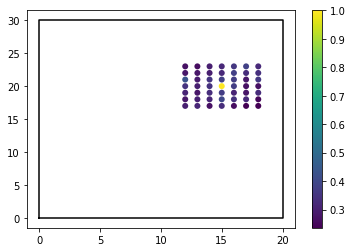

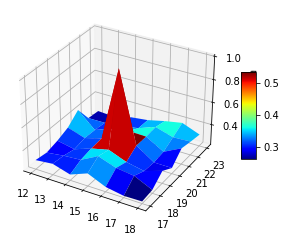

In [558]:
receptor1 = [5,7]
receptor2 = [10,20]
source = [15,20]
order = 30

X,Y, corr = focalisation(receptor1,receptor2, source, order, graph = True, Type = True)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.figsize=(20, 20)
surf = ax.plot_surface(X, Y, np.array(corr), cmap=cm.jet,linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.4, aspect=6)
ax.set_zlabel('Correlation')
plt.show()



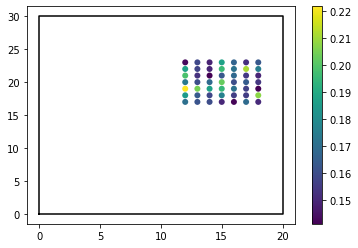

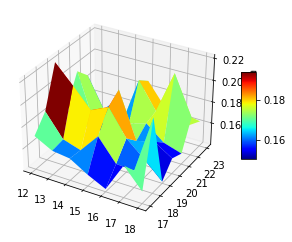

In [560]:
X,Y, corr = focalisation(receptor1,receptor2, source, order, graph = True, Type = False)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig.figsize=(20, 20)
surf = ax.plot_surface(X, Y, np.array(corr), cmap=cm.jet,linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.4, aspect=6)
ax.set_zlabel('Correlation')
plt.show()


Avec la definition de correlation de phase trouvé, la focalisation n'est pas correcte.